In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import duckdb
import warnings
import json
import ast
import re
from collections import Counter
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
sns.set_palette("Set2")


In [2]:
# Load Parquet file using DuckDB
file_path = 'client_part_collection_sample.parquet'
df = duckdb.query(f"SELECT * FROM '{file_path}'").to_df()

In [3]:
df.head()

,client_id,country,region_id,currency,data_quality,date_added,part_id,unit,sonar_results
0,668e3fb5d2b001a3ad500b8f,DEU,64802c55292b179f4df8e204,EUR,medium,2024-03-21T00:00:00.000Z,65fc34fe23f1a95acc644f69,ST,"[{'amount': 1, 'currency': None, 'date_sonar':..."
1,65577268e32ff87ee1056f82,DEU,64802c55292b179f4df8e204,EUR,medium,2024-03-21T00:00:00.000Z,65fc350123f1a95acc644fe2,ST,"[{'amount': 1, 'currency': None, 'date_sonar':..."
2,65577268e32ff87ee1056f82,DEU,64802c55292b179f4df8e204,EUR,high,2024-05-23T00:00:00.000Z,664f109c58aa1e07d4930646,ST,<NA>
3,65577268e32ff87ee1056f82,DEU,64802c55292b179f4df8e204,EUR,medium,2024-05-23T00:00:00.000Z,664f109c58aa1e07d493064e,ST,<NA>
4,668e3fb5d2b001a3ad500b8f,DEU,64802c55292b179f4df8e204,EUR,high,2024-05-23T00:00:00.000Z,664f109c58aa1e07d4930652,ST,<NA>


In [4]:
def parse_sonar_results(sonar_results):
    """Parses sonar_results from mixed string/list formats to a list of dicts."""
    
    # --- FIXED empty checking ---
    if sonar_results is None:
        return []

    if isinstance(sonar_results, float) and pd.isna(sonar_results):
        return []

    if isinstance(sonar_results, str) and sonar_results.strip() == '':
        return []
    # ----------------------------

    # Handle direct list
    if isinstance(sonar_results, list):
        return sonar_results

    # Handle string input - make sure it's actually a string
    try:
        if not isinstance(sonar_results, str):
            sonar_results = str(sonar_results)
            
        cleaned = sonar_results.strip().replace('\n', '').replace('} {', '}, {')
        if not cleaned.startswith('['): cleaned = '[' + cleaned
        if not cleaned.endswith(']'): cleaned += ']'
        
        # Try JSON parsing
        try:
            return json.loads(cleaned)
        except json.JSONDecodeError:
            pass
        
        # Try ast.literal_eval
        try:
            return ast.literal_eval(cleaned.replace("'", '"'))
        except Exception:
            pass
        
        # Regex fallback
        try:
            matches = re.findall(r"\{[^{}]*\}", sonar_results)
            parsed = []
            for match in matches:
                try:
                    match = match.replace("'", '"').replace("None", "null")
                    parsed.append(json.loads(match))
                except:
                    continue
            return parsed
        except Exception:
            return []
            
    except Exception:
        return []


In [5]:
def extract_sonar_metrics(sonar_results):
    """
    Extract key metrics from sonar_results without storing the full parsed data
    Returns a dict with count, price stats, and status counts
    """
    parsed = parse_sonar_results(sonar_results)
    
    if not parsed:
        return {
            'count': 0,
            'avg_price': np.nan,
            'min_price': np.nan,
            'max_price': np.nan,
            'verified_count': 0,
            'unverified_count': 0,
            'supplier_countries': [],
            'supplier_count': 0
        }
    
    prices = []
    verified_count = 0
    unverified_count = 0
    supplier_countries = set()
    supplier_ids = set()
    
    for result in parsed:
        # Extract price
        if isinstance(result, dict) and 'price' in result and result['price'] is not None:
            try:
                price = float(result['price'])
                prices.append(price)
            except (ValueError, TypeError):
                pass
        
        # Count verification status - fix the comparison
        if isinstance(result, dict):
            status = result.get('status')
            if status == 'verified':
                verified_count += 1
            elif status == 'unverified':
                unverified_count += 1
        
        # Track supplier countries
        if isinstance(result, dict) and 'supplier_country' in result and result['supplier_country']:
            supplier_countries.add(result['supplier_country'])
        
        # Track unique suppliers
        if isinstance(result, dict) and 'supplier_id' in result and result['supplier_id']:
            supplier_ids.add(result['supplier_id'])
    
    return {
        'count': len(parsed),
        'avg_price': np.mean(prices) if prices else np.nan,
        'min_price': min(prices) if prices else np.nan,
        'max_price': max(prices) if prices else np.nan,
        'verified_count': verified_count,
        'unverified_count': unverified_count,
        'supplier_countries': list(supplier_countries),
        'supplier_count': len(supplier_ids)
    }

In [6]:
def fast_sonar_metrics(df):
    """
    Quickly extract key metrics from sonar_results without storing parsed data
    Returns a DataFrame with added sonar metric columns
    """
    print("Extracting sonar metrics...")
    
    # Create a copy of the dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Apply extraction function with error handling
    metrics = []
    
    for i, row in result_df.iterrows():
        try:
            metrics.append(extract_sonar_metrics(row['sonar_results']))
        except Exception as e:
            # If error, add a row of default values
            metrics.append({
                'count': 0, 'avg_price': np.nan, 'min_price': np.nan, 'max_price': np.nan,
                'verified_count': 0, 'unverified_count': 0,
                'supplier_countries': [], 'supplier_count': 0
            })
    
    # Convert the list of dicts to a DataFrame and add as columns
    metrics_df = pd.DataFrame(metrics, index=result_df.index)
    
    # Add metrics columns to the original dataframe
    for col in metrics_df.columns:
        result_df[f'sonar_{col}'] = metrics_df[col]
    
    return result_df

In [7]:
def debug_sonar_parsing():
    """Debug function to check sonar parsing on a small sample."""
    # Load the data
    file_path = 'client_part_collection_sample.parquet'
    df = duckdb.query(f"SELECT * FROM '{file_path}'").to_df()
    
    # Take a small sample
    sample = df.head(5)
    
    for i, row in sample.iterrows():
        print(f"\nRow {i}:")
        sonar_data = row['sonar_results']
        print(f"Type: {type(sonar_data)}")
        print(f"Sample: {str(sonar_data)[:100]}...")
        
        try:
            parsed = parse_sonar_results(sonar_data)
            print(f"Successfully parsed {len(parsed)} items")
            
            metrics = extract_sonar_metrics(sonar_data)
            print("Metrics extracted successfully:")
            for k, v in metrics.items():
                if k != 'supplier_countries':  # Skip the potentially long list
                    print(f"  {k}: {v}")
                else:
                    print(f"  {k}: {len(v)} countries")
                    
        except Exception as e:
            print(f"Error: {e}")
    
    print("\nDebug complete")

# Call the debug function
# debug_sonar_parsing()

In [8]:
def process_sonar_chunks(df, chunk_size=1000):
    """
    Process sonar data in chunks to avoid memory issues
    Returns a DataFrame with sonar metrics
    """
    print(f"Processing sonar data in chunks of {chunk_size}...")
    
    all_sonar_data = []
    total_rows = len(df)
    
    for i in range(0, total_rows, chunk_size):
        end_idx = min(i + chunk_size, total_rows)
        print(f"Processing chunk {i//chunk_size + 1}/{(total_rows+chunk_size-1)//chunk_size}...")
        
        chunk = df.iloc[i:end_idx]
        
        # Process each row in the chunk
        for idx, row in chunk.iterrows():
            parsed = parse_sonar_results(row['sonar_results'])
            
            for result in parsed:
                result_copy = result.copy()
                result_copy['client_id'] = row['client_id']
                result_copy['part_id'] = row['part_id']
                result_copy['client_country'] = row['country']
                
                # Only keep essential fields to save memory
                essential_fields = [
                    'client_id', 'part_id', 'client_country', 
                    'supplier_id', 'supplier_name', 'supplier_country',
                    'price', 'delivery', 'status', 'date_sonar'
                ]
                
                filtered_result = {k: result_copy.get(k) for k in essential_fields if k in result_copy}
                all_sonar_data.append(filtered_result)
    
    # Convert to DataFrame
    sonar_df = pd.DataFrame(all_sonar_data)
    
    # Convert types
    if 'date_sonar' in sonar_df.columns:
        sonar_df['date_sonar'] = pd.to_datetime(sonar_df['date_sonar'], errors='coerce')
    
    if 'price' in sonar_df.columns:
        sonar_df['price'] = pd.to_numeric(sonar_df['price'], errors='coerce')
    
    return sonar_df


In [9]:
# Main Data
# Function for main data exploration (non-sonar fields)
def explore_main_data(df):
    """
    Analyze the main dataframe (excluding detailed sonar analysis)
    """
    print("\n1. BASIC DATASET EXPLORATION")
    print("-" * 50)
    
    # Basic info about the dataset
    print("\n1.1 Dataset Shape:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    
    print("\n1.2 Column Names and Data Types:")
    print(df.dtypes)
    
    print("\n1.3 Sample Data:")
    print(df.head())
    
    print("\n1.4 Basic Statistics:")
    print(df.describe(include='all').T)
    
    print("\n1.5 Missing Values Analysis:")
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percentage
    })
    print(missing_df[missing_df['Missing Values'] > 0])
    
    print("\n2. CATEGORICAL VARIABLES ANALYSIS")
    print("-" * 50)
    
    categorical_cols = ['country', 'currency', 'data_quality', 'unit']
    
    for col in categorical_cols:
        if col in df.columns:
            value_counts = df[col].value_counts()
            print(f"\n2.{categorical_cols.index(col) + 1} {col.capitalize()} Distribution:")
            print(value_counts.head(10))  # Show only top 10
            print(f"Total unique values: {df[col].nunique()}")
    
    print("\n3. TEMPORAL ANALYSIS")
    print("-" * 50)
    
    # Convert date columns
    if 'date_added' in df.columns:
        df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
        
        print("\n3.1 Distribution of date_added:")
        print(df['date_added'].describe())
        
        print("\n3.2 Parts Added by Month:")
        monthly_counts = df['date_added'].dt.to_period('M').value_counts().sort_index()
        print(monthly_counts)
    
    print("\n4. SONAR METRICS SUMMARY")
    print("-" * 50)
    
    sonar_metrics_cols = [col for col in df.columns if col.startswith('sonar_')]
    
    if sonar_metrics_cols:
        print("\n4.1 Sonar Metrics Overview:")
        print(df[sonar_metrics_cols].describe())
        
        print("\n4.2 Distribution of Results per Entry:")
        print(df['sonar_count'].value_counts().sort_index().head(10))
        print(f"Maximum results per entry: {df['sonar_count'].max()}")
        print(f"Average results per entry: {df['sonar_count'].mean():.2f}")
        
        print("\n4.3 Verification Rate:")
        total_verified = df['sonar_verified_count'].sum()
        total_unverified = df['sonar_unverified_count'].sum()
        total_results = total_verified + total_unverified
        
        if total_results > 0:
            print(f"Verified: {total_verified} ({total_verified/total_results*100:.2f}%)")
            print(f"Unverified: {total_unverified} ({total_unverified/total_results*100:.2f}%)")
        
        print("\n4.4 Price Statistics:")
        print(f"Average price: {df['sonar_avg_price'].mean():.2f}")
        print(f"Minimum price: {df['sonar_min_price'].min():.2f}")
        print(f"Maximum price: {df['sonar_max_price'].max():.2f}")
        
        # Supplier country analysis (flattened from lists)
        all_countries = []
        for countries in df['sonar_supplier_countries'].dropna():
            if isinstance(countries, list):
                all_countries.extend(countries)
        
        country_counts = Counter(all_countries)
        print("\n4.5 Top Supplier Countries:")
        for country, count in country_counts.most_common(10):
            print(f"{country}: {count}")

In [10]:
# Exploring Soner Data
def explore_sonar_data(sonar_df):
    """
    Analyze the detailed sonar dataframe
    """
    print("\n5. SONAR DETAILED ANALYSIS")
    print("-" * 50)
    
    print("\n5.1 Sonar DataFrame Info:")
    print(f"Rows: {sonar_df.shape[0]}, Columns: {sonar_df.shape[1]}")
    print(sonar_df.dtypes)
    
    print("\n5.2 Sonar Sample Data:")
    print(sonar_df.head())
    
    print("\n5.3 Sonar Basic Statistics:")
    print(sonar_df.describe())
    
    print("\n5.4 Sonar Missing Values:")
    sonar_missing = sonar_df.isnull().sum()
    sonar_missing_pct = (sonar_missing / len(sonar_df)) * 100
    sonar_missing_df = pd.DataFrame({
        'Missing Values': sonar_missing,
        'Percentage': sonar_missing_pct
    })
    print(sonar_missing_df[sonar_missing_df['Missing Values'] > 0])
    
    print("\n6. CATEGORICAL ANALYSIS")
    print("-" * 50)
    
    categorical_cols = ['supplier_country', 'supplier_name', 'status']
    
    for col in categorical_cols:
        if col in sonar_df.columns:
            value_counts = sonar_df[col].value_counts()
            print(f"\n6.{categorical_cols.index(col) + 1} {col.capitalize()} Distribution:")
            print(value_counts.head(10))  # Show only top 10
            print(f"Total unique values: {sonar_df[col].nunique()}")
    
    print("\n7. PRICE ANALYSIS")
    print("-" * 50)
    
    if 'price' in sonar_df.columns:
        print("\n7.1 Price Distribution Statistics:")
        print(sonar_df['price'].describe())
        
        print("\n7.2 Price Distribution by Supplier Country:")
        price_by_country = sonar_df.groupby('supplier_country')['price'].agg(['mean', 'median', 'min', 'max', 'count'])
        print(price_by_country.head(10))
        
        print("\n7.3 Price Distribution by Status:")
        price_by_status = sonar_df.groupby('status')['price'].agg(['mean', 'median', 'min', 'max', 'count'])
        print(price_by_status)
        
        # Calculate price quartiles for outlier detection
        q1 = sonar_df['price'].quantile(0.25)
        q3 = sonar_df['price'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = sonar_df[(sonar_df['price'] < lower_bound) | (sonar_df['price'] > upper_bound)]
        
        print("\n7.4 Price Outliers (using IQR method):")
        print(f"Number of price outliers: {len(outliers)}")
        print(f"Percentage of price outliers: {len(outliers) / len(sonar_df) * 100:.2f}%")
        if len(outliers) > 0:
            print("Sample of outliers:")
            print(outliers[['price', 'supplier_name', 'status', 'supplier_country']].head())
    
    print("\n8. TEMPORAL ANALYSIS")
    print("-" * 50)
    
    if 'date_sonar' in sonar_df.columns:
        print("\n8.1 Distribution of sonar dates:")
        print(sonar_df['date_sonar'].describe())
        
        print("\n8.2 Sonar Results by Month:")
        monthly_counts = sonar_df['date_sonar'].dt.to_period('M').value_counts().sort_index()
        print(monthly_counts.head(10))
        
        if 'price' in sonar_df.columns:
            # Group by month and analyze price trends
            sonar_df['month_year'] = sonar_df['date_sonar'].dt.to_period('M')
            price_trend = sonar_df.groupby('month_year')['price'].agg(['mean', 'median', 'min', 'max', 'count'])
            
            print("\n8.3 Price Trends Over Time:")
            print(price_trend.head(10))
    
    print("\n9. DELIVERY ANALYSIS")
    print("-" * 50)
    
    if 'delivery' in sonar_df.columns:
        print("\n9.1 Delivery Value Counts:")
        delivery_counts = sonar_df['delivery'].value_counts().head(10)
        print(delivery_counts)
        
        print("\n9.2 Delivery Statistics (excluding -99):")
        real_delivery = sonar_df[sonar_df['delivery'] != -99]['delivery']
        if len(real_delivery) > 0:
            print(real_delivery.describe())
        else:
            print("No real delivery values available (all are -99).")
    
    print("\n10. RELATIONSHIP ANALYSIS")
    print("-" * 50)
    
    if all(col in sonar_df.columns for col in ['price', 'delivery']):
        print("\n10.1 Correlation between Price and Delivery (where delivery != -99):")
        valid_delivery_df = sonar_df[sonar_df['delivery'] != -99]
        if not valid_delivery_df.empty:
            price_delivery_corr = valid_delivery_df['price'].corr(valid_delivery_df['delivery'])
            print(f"Correlation: {price_delivery_corr:.4f}")
        else:
            print("Cannot calculate correlation - no valid delivery values.")
    
    if all(col in sonar_df.columns for col in ['price', 'status']):
        print("\n10.2 Price Comparison: Verified vs Unverified:")
        verified_price = sonar_df[sonar_df['status'] == 'verified']['price']
        unverified_price = sonar_df[sonar_df['status'] == 'unverified']['price']
        
        if not verified_price.empty and not unverified_price.empty:
            print(f"Verified mean price: {verified_price.mean():.2f}")
            print(f"Unverified mean price: {unverified_price.mean():.2f}")
            print(f"Difference: {verified_price.mean() - unverified_price.mean():.2f}")
        else:
            print("Cannot compare - missing verified or unverified prices.")
    
    print("\n11. SUPPLIER ANALYSIS")
    print("-" * 50)
    
    if 'supplier_name' in sonar_df.columns:
        print("\n11.1 Results per Supplier:")
        results_per_supplier = sonar_df['supplier_name'].value_counts().head(10)
        print(results_per_supplier)
        
        if 'price' in sonar_df.columns:
            print("\n11.2 Average Price per Supplier:")
            price_per_supplier = sonar_df.groupby('supplier_name')['price'].mean().sort_values()
            print(price_per_supplier.head(10))
    
    print("\n12. SUMMARY INSIGHTS")
    print("-" * 50)
    
    print("\n12.1 Key Metrics:")
    print(f"Total number of sonar results: {len(sonar_df)}")
    print(f"Total number of unique clients: {sonar_df['client_id'].nunique()}")
    print(f"Total number of unique parts: {sonar_df['part_id'].nunique()}")
    print(f"Total number of unique suppliers: {sonar_df['supplier_id'].nunique() if 'supplier_id' in sonar_df.columns else 'N/A'}")
    
    if 'price' in sonar_df.columns:
        print(f"Average price: {sonar_df['price'].mean():.2f}")
    
    if 'status' in sonar_df.columns:
        verified_count = (sonar_df['status'] == 'verified').sum()
        print(f"Verification rate: {verified_count / len(sonar_df) * 100:.2f}%")
    
    if 'date_sonar' in sonar_df.columns:
        print(f"Date range: {sonar_df['date_sonar'].min()} to {sonar_df['date_sonar'].max()}")


In [11]:
def print_recommendations_and_next_steps():
    """
    Print recommendations and next steps
    """
    print("\n14. RECOMMENDATIONS & INSIGHTS")
    print("-" * 50)
    print("""
    Based on the analysis, here are some key insights and recommendations:
    
    1. DATA QUALITY:
       - Address missing values in the dataset, particularly in the sonar results
       - Standardize the delivery time reporting (many values are -99)
       - Investigate entries with low data quality scores
    
    # ... (remaining recommendations)
    """)
    
    print("\n15. NEXT STEPS")
    print("-" * 50)
    print("""
    For further analysis, consider these next steps:
    
    1. TARGETED DEEP DIVES:
       - Focus on high-volume parts or strategic suppliers
       - Analyze specific geographical markets in detail
       - Investigate price outliers and unusual patterns
    
    # ... (remaining next steps)
    """)

In [12]:
def perform_detailed_sonar_analysis(df):
    """
    Perform detailed sonar analysis with appropriate sampling
    """
    sonar_sample_size = min(len(df), 50000) if len(df) > 50000 else len(df)
    
    if len(df) > sonar_sample_size:
        print(f"Using a sample of {sonar_sample_size} rows for detailed sonar analysis")
        return process_sonar_chunks(df.sample(sonar_sample_size), chunk_size=1000)
    else:
        return process_sonar_chunks(df, chunk_size=1000)

def create_visualizations(df, sonar_df):
    """
    Create and display all visualizations
    """
    print("\n13. VISUALIZATION CODE")
    print("-" * 50)
    print("Creating visualizations...")
    
    # Main visualizations
    plot_main_visualizations(sonar_df)
    
    # Additional visualizations
    plot_delivery_distribution(sonar_df)
    plot_price_trends_by_supplier(sonar_df)
    plot_price_by_data_quality(df, sonar_df)

def plot_main_visualizations(sonar_df):
    """
    Create the main set of visualizations
    """
    plt.figure(figsize=(15, 10))
    
    # 1. Price Distribution
    plt.subplot(2, 3, 1)
    if 'price' in sonar_df.columns:
        sns.histplot(sonar_df['price'], kde=True, bins=30)
        plt.title('Price Distribution')
        plt.xlabel('Price')
        plt.ylabel('Frequency')
    
    # 2. Price by Supplier Country
    plt.subplot(2, 3, 2)
    if all(col in sonar_df.columns for col in ['supplier_country', 'price']):
        top_countries = sonar_df['supplier_country'].value_counts().nlargest(5).index
        country_data = sonar_df[sonar_df['supplier_country'].isin(top_countries)]
        sns.boxplot(x='supplier_country', y='price', data=country_data)
        plt.title('Price by Top Supplier Countries')
        plt.xticks(rotation=45)
    
    # Continue with other plots...
    # (Remaining subplot code would be here)
    
    plt.tight_layout()
    plt.savefig('sonar_analysis.png')
    plt.show()

def plot_delivery_distribution(sonar_df):
    """
    Plot the delivery time distribution
    """
    if 'delivery' in sonar_df.columns:
        plt.figure(figsize=(10, 6))
        valid_delivery = sonar_df[sonar_df['delivery'] != -99]
        if len(valid_delivery) > 0:
            sns.histplot(valid_delivery['delivery'], kde=True, bins=30)
            plt.title('Delivery Time Distribution (excluding unknown values)')
            plt.xlabel('Delivery Time (days)')
            plt.ylabel('Frequency')
            plt.savefig('delivery_distribution.png')
            plt.show()

def plot_price_trends_by_supplier(sonar_df):
    """
    Plot price trends by top suppliers
    """
    if all(col in sonar_df.columns for col in ['supplier_name', 'date_sonar', 'price']):
        plt.figure(figsize=(12, 8))
        top_suppliers = sonar_df['supplier_name'].value_counts().nlargest(5).index
        supplier_data = sonar_df[sonar_df['supplier_name'].isin(top_suppliers)]
        
        # Sample for faster plotting if needed
        if len(supplier_data) > 10000:
            supplier_data = supplier_data.sample(10000)
        
        supplier_data['month_year'] = supplier_data['date_sonar'].dt.to_period('M').dt.to_timestamp()
        sns.lineplot(x='month_year', y='price', hue='supplier_name', data=supplier_data)
        plt.title('Price Trends by Top Suppliers Over Time')
        plt.xlabel('Date')
        plt.ylabel('Average Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('price_trends_by_supplier.png')
        plt.show()

def plot_price_by_data_quality(df, sonar_df):
    """
    Plot price distribution by data quality
    """
    if all(col in sonar_df.columns for col in ['client_id', 'price']) and 'data_quality' in df.columns:
        plt.figure(figsize=(10, 6))
        merged_data = pd.merge(
            sonar_df[['client_id', 'price']], 
            df[['client_id', 'data_quality']], 
            on='client_id', 
            how='inner'
        )
        
        sns.boxplot(x='data_quality', y='price', data=merged_data)
        plt.title('Price Distribution by Data Quality')
        plt.xlabel('Data Quality')
        plt.ylabel('Price')
        plt.tight_layout()
        plt.savefig('price_by_data_quality.png')
        plt.show()

In [13]:
def visualize_sonar(df):
    """Visual summary of client part collection data."""
    try:
        fig = plt.figure(figsize=(18, 10))

        # 1. Country Distribution
        plt.subplot(2, 3, 1)
        if 'country' in df.columns:
            sns.countplot(data=df, x='country', order=df['country'].value_counts().nlargest(10).index)
            plt.title('Country Distribution (Top 10)')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'country column not available', ha='center')

        # 2. Region Distribution
        plt.subplot(2, 3, 2)
        if 'region_id' in df.columns:
            sns.countplot(data=df, x='region_id', order=df['region_id'].value_counts().nlargest(10).index)
            plt.title('Region Distribution (Top 10)')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'region_id column not available', ha='center')

        # 3. Currency Distribution
        plt.subplot(2, 3, 3)
        if 'currency' in df.columns:
            sns.countplot(data=df, x='currency', order=df['currency'].value_counts().nlargest(10).index)
            plt.title('Currency Usage (Top 10)')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'currency column not available', ha='center')

        # 4. Data Quality Distribution
        plt.subplot(2, 3, 4)
        if 'data_quality' in df.columns:
            sns.countplot(data=df, x='data_quality', order=df['data_quality'].value_counts().index)
            plt.title('Data Quality Ratings')
        else:
            plt.text(0.5, 0.5, 'data_quality column not available', ha='center')

        # 5. Unit Distribution
        plt.subplot(2, 3, 5)
        if 'unit' in df.columns:
            sns.countplot(data=df, x='unit', order=df['unit'].value_counts().nlargest(10).index)
            plt.title('Unit Types (Top 10)')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'unit column not available', ha='center')

        # 6. Date Added Over Time
        plt.subplot(2, 3, 6)
        if 'date_added' in df.columns:
            # Ensure date_added is datetime
            if not pd.api.types.is_datetime64_any_dtype(df['date_added']):
                df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
                
            # Create year_month column
            if pd.api.types.is_datetime64_any_dtype(df['date_added']):
                year_month = df['date_added'].dt.to_period('M')
                year_month.value_counts().sort_index().tail(12).plot(kind='bar')
                plt.title('Entries Over Last 12 Months')
                plt.xlabel('Year-Month')
                plt.xticks(rotation=45)
            else:
                plt.text(0.5, 0.5, 'date_added conversion to datetime failed', ha='center')
        else:
            plt.text(0.5, 0.5, 'date_added column not available', ha='center')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in visualization: {e}")

In [14]:
def visualize_sonar_details(sonar_df):
    """Visual summary of processed sonar data."""
    try:
        fig = plt.figure(figsize=(18, 10))
        
        # 1. Price Distribution
        plt.subplot(2, 2, 1)
        if 'sonar_avg_price' in sonar_df.columns:
            sns.histplot(sonar_df['sonar_avg_price'].dropna(), kde=True, bins=30)
            plt.title('Average Price Distribution')
            plt.xlabel('Average Price')
            plt.ylabel('Frequency')
        else:
            plt.text(0.5, 0.5, 'Price data not available', ha='center')
        
        # 2. Sonar Results Count Distribution
        plt.subplot(2, 2, 2)
        if 'sonar_count' in sonar_df.columns:
            sns.countplot(data=sonar_df, x='sonar_count', 
                          order=sorted(sonar_df['sonar_count'].value_counts().index)[:10])
            plt.title('Number of Sonar Results per Entry (Top 10)')
            plt.xlabel('Number of Results')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'Sonar count data not available', ha='center')
        
        # 3. Verification Rate
        plt.subplot(2, 2, 3)
        if all(col in sonar_df.columns for col in ['sonar_verified_count', 'sonar_unverified_count']):
            verification_data = pd.DataFrame({
                'Status': ['Verified', 'Unverified'],
                'Count': [
                    sonar_df['sonar_verified_count'].sum(),
                    sonar_df['sonar_unverified_count'].sum()
                ]
            })
            sns.barplot(data=verification_data, x='Status', y='Count')
            plt.title('Verification Status Counts')
            plt.ylabel('Count')
        else:
            plt.text(0.5, 0.5, 'Verification data not available', ha='center')
        
        # 4. Top Supplier Countries
        plt.subplot(2, 2, 4)
        if 'sonar_supplier_countries' in sonar_df.columns:
            # Flatten the list of supplier countries
            all_countries = []
            for countries in sonar_df['sonar_supplier_countries'].dropna():
                if isinstance(countries, list):
                    all_countries.extend(countries)
            
            if all_countries:
                country_counts = pd.Series(Counter(all_countries)).nlargest(10)
                country_df = pd.DataFrame({'Country': country_counts.index, 'Count': country_counts.values})
                sns.barplot(data=country_df, x='Country', y='Count')
                plt.title('Top 10 Supplier Countries')
                plt.xticks(rotation=45)
            else:
                plt.text(0.5, 0.5, 'No supplier countries data found', ha='center')
        else:
            plt.text(0.5, 0.5, 'Supplier countries data not available', ha='center')
            
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in sonar visualization: {e}")

In [15]:
sonar_df = process_sonar_chunks(df)

Processing sonar data in chunks of 1000...
Processing chunk 1/277...
Processing chunk 2/277...
Processing chunk 3/277...
Processing chunk 4/277...
Processing chunk 5/277...
Processing chunk 6/277...
Processing chunk 7/277...
Processing chunk 8/277...
Processing chunk 9/277...
Processing chunk 10/277...
Processing chunk 11/277...
Processing chunk 12/277...
Processing chunk 13/277...
Processing chunk 14/277...
Processing chunk 15/277...
Processing chunk 16/277...
Processing chunk 17/277...
Processing chunk 18/277...
Processing chunk 19/277...
Processing chunk 20/277...
Processing chunk 21/277...
Processing chunk 22/277...
Processing chunk 23/277...
Processing chunk 24/277...
Processing chunk 25/277...
Processing chunk 26/277...
Processing chunk 27/277...
Processing chunk 28/277...
Processing chunk 29/277...
Processing chunk 30/277...
Processing chunk 31/277...
Processing chunk 32/277...
Processing chunk 33/277...
Processing chunk 34/277...
Processing chunk 35/277...
Processing chunk 36/2

In [16]:
print("Available columns:", sonar_df.columns.tolist())

Available columns: ['client_id', 'part_id', 'client_country', 'supplier_id', 'supplier_name', 'supplier_country', 'price', 'delivery', 'status', 'date_sonar']


In [17]:
sns.set_style('whitegrid')

In [18]:
# Before Moving into Basic Statistics we need to exclude the Sonar Result column due to its nature

In [19]:
df = df[['client_id', 'country', 'region_id', 'currency', 'data_quality', 'date_added', 'part_id', 'unit']]

In [20]:
# Summary of Main Dataset
print("------ Basic Information of Main Data ------- ")
df.info()


# Statistical overview
print("------ Basic Statistics of Data -------")
df.describe()


# Check for missing values
print("------ Missing Values -------")
df.isnull().sum()

# Shape of the dataset
print("------ Data Size -------")
df.shape


------ Basic Information of Main Data ------- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276963 entries, 0 to 276962
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     276963 non-null  object
 1   country       275510 non-null  object
 2   region_id     276963 non-null  object
 3   currency      276963 non-null  object
 4   data_quality  276963 non-null  object
 5   date_added    213721 non-null  object
 6   part_id       276351 non-null  object
 7   unit          276664 non-null  object
dtypes: object(8)
memory usage: 16.9+ MB
------ Basic Statistics of Data -------
------ Missing Values -------
------ Data Size -------


(276963, 8)

In [21]:
# Summary of Sonar Dataset
print("------ Basic Information of Main Data ------- ")
sonar_df.info()


# Statistical overview
print("------ Basic Statistics of Data -------")
sonar_df.describe()


# Check for missing values
print("------ Missing Values -------")
sonar_df.isnull().sum()

# Shape of the dataset
print("------ Data Size -------")
sonar_df.shape


------ Basic Information of Main Data ------- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4068152 entries, 0 to 4068151
Data columns (total 10 columns):
 #   Column            Dtype              
---  ------            -----              
 0   client_id         object             
 1   part_id           object             
 2   client_country    object             
 3   supplier_id       object             
 4   supplier_name     object             
 5   supplier_country  object             
 6   price             float64            
 7   delivery          int64              
 8   status            object             
 9   date_sonar        datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(7)
memory usage: 310.4+ MB
------ Basic Statistics of Data -------
------ Missing Values -------
------ Data Size -------


(4068152, 10)

In [22]:
# Example
# df = pd.read_parquet("client_part_collection_sample.parquet")
sonar_df = df.copy()  # or however you define sonar_df



In [23]:
def run_analysis():
    """Main function to run the complete analysis pipeline."""
    try:
        print("Loading and processing data...")
        
        # Load the data
        file_path = 'client_part_collection_sample.parquet'
        df = duckdb.query(f"SELECT * FROM '{file_path}'").to_df()
        
        print(f"Loaded data with {len(df)} rows and {len(df.columns)} columns")
        
        # Process date columns
        if 'date_added' in df.columns:
            df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
        
        # Extract sonar metrics
        print("Extracting sonar metrics...")
        df_with_metrics = fast_sonar_metrics(df)
        
        # Basic visualizations
        print("Generating basic visualizations...")
        visualize_sonar(df)
        
        # Sonar detail visualizations
        print("Generating sonar detail visualizations...")
        visualize_sonar_details(df_with_metrics)
        
        # Main data exploration
        print("Exploring main data...")
        explore_main_data(df_with_metrics)
        
        # Detailed sonar analysis (optional - can be resource intensive)
        perform_detailed = input("Perform detailed sonar analysis? (y/n): ").lower() == 'y'
        if perform_detailed:
            print("Performing detailed sonar analysis...")
            sonar_detailed_df = perform_detailed_sonar_analysis(df)
            explore_sonar_data(sonar_detailed_df)
            
        # Print recommendations
        print_recommendations_and_next_steps()
        
        print("Analysis complete!")
        
    except Exception as e:
        print(f"Error in analysis: {e}")

In [24]:
def analyze_sonar_sample(df, sample_size=5):
    """Analyze a small sample of sonar results for debugging."""
    try:
        print(f"Analyzing sample of {sample_size} sonar results...")
        sample = df.sample(min(sample_size, len(df)))
        
        for i, (idx, row) in enumerate(sample.iterrows()):
            print(f"\nSample {i+1} (ID: {row['client_id']} - {row['part_id']}):")
            print(f"Sonar results type: {type(row['sonar_results'])}")
            print(f"Sample content: {str(row['sonar_results'])[:100]}...")
            
            parsed = parse_sonar_results(row['sonar_results'])
            print(f"Parsed {len(parsed)} results")
            
            if parsed:
                print("First parsed item:")
                for k, v in list(parsed[0].items())[:5]:
                    print(f"  {k}: {v}")
                    
    except Exception as e:
        print(f"Error in sample analysis: {e}")

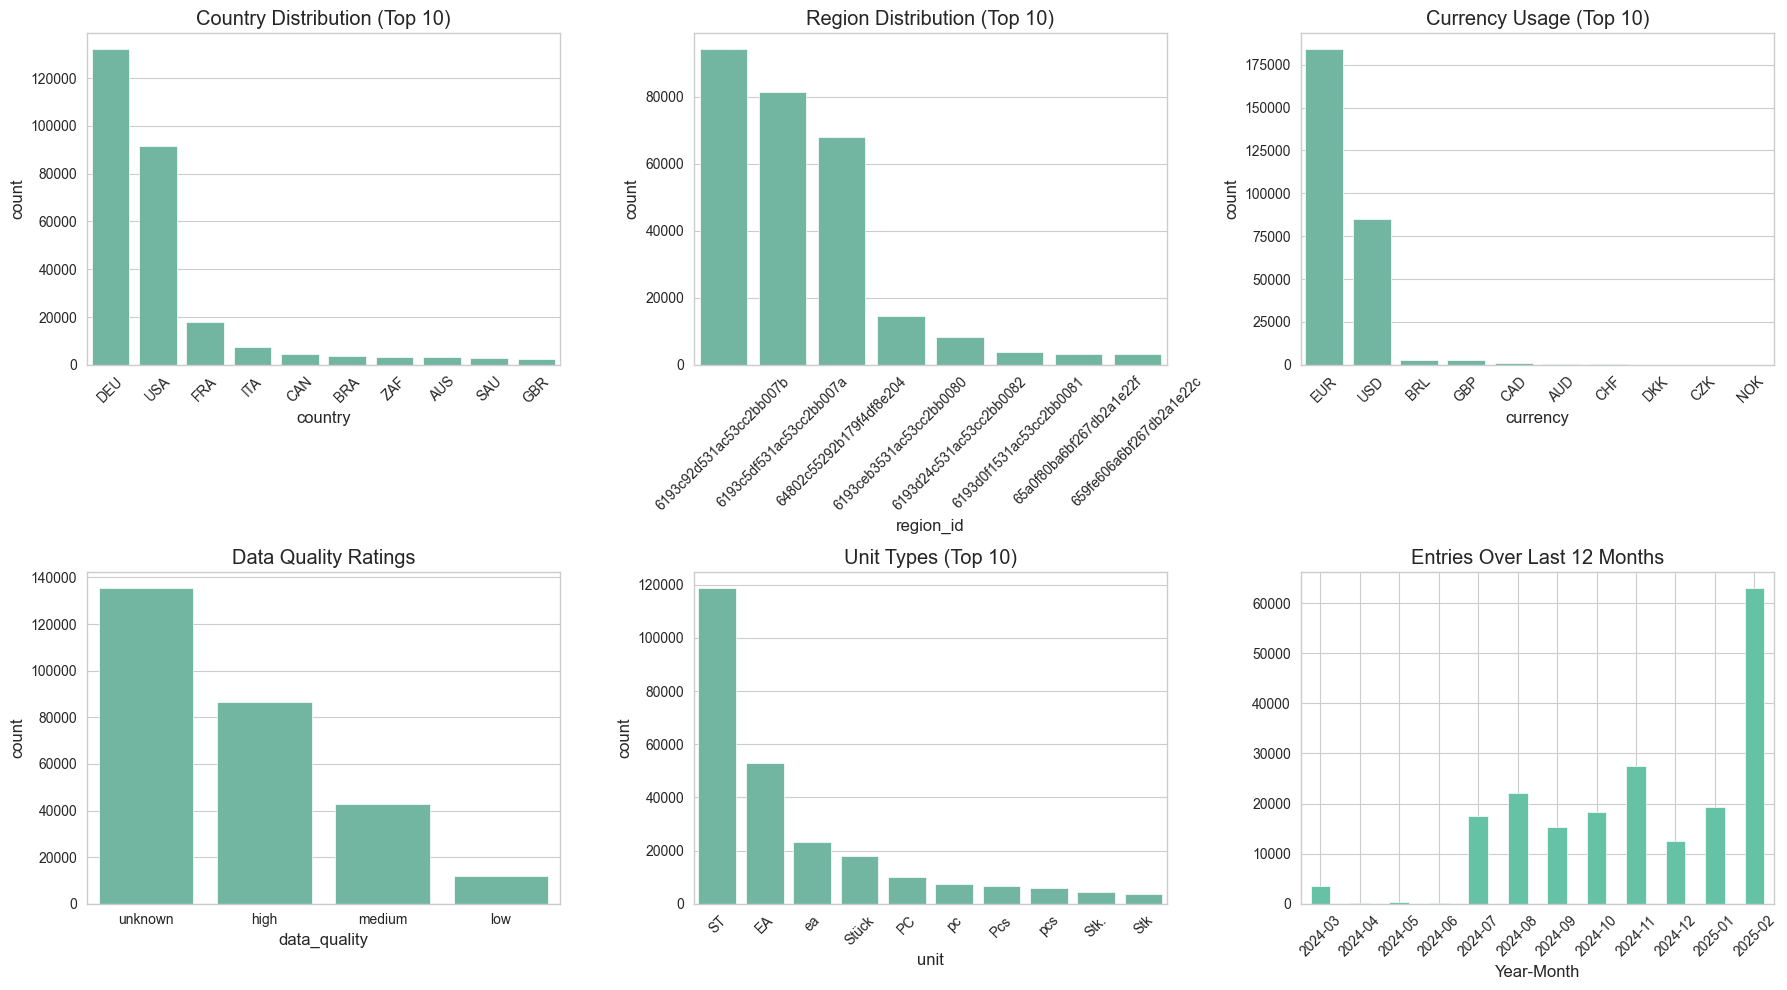

In [26]:
visualize_sonar(df)

Loading and processing data...
Loaded data with 276963 rows and 9 columns
Extracting sonar metrics...
Extracting sonar metrics...
Generating basic visualizations...


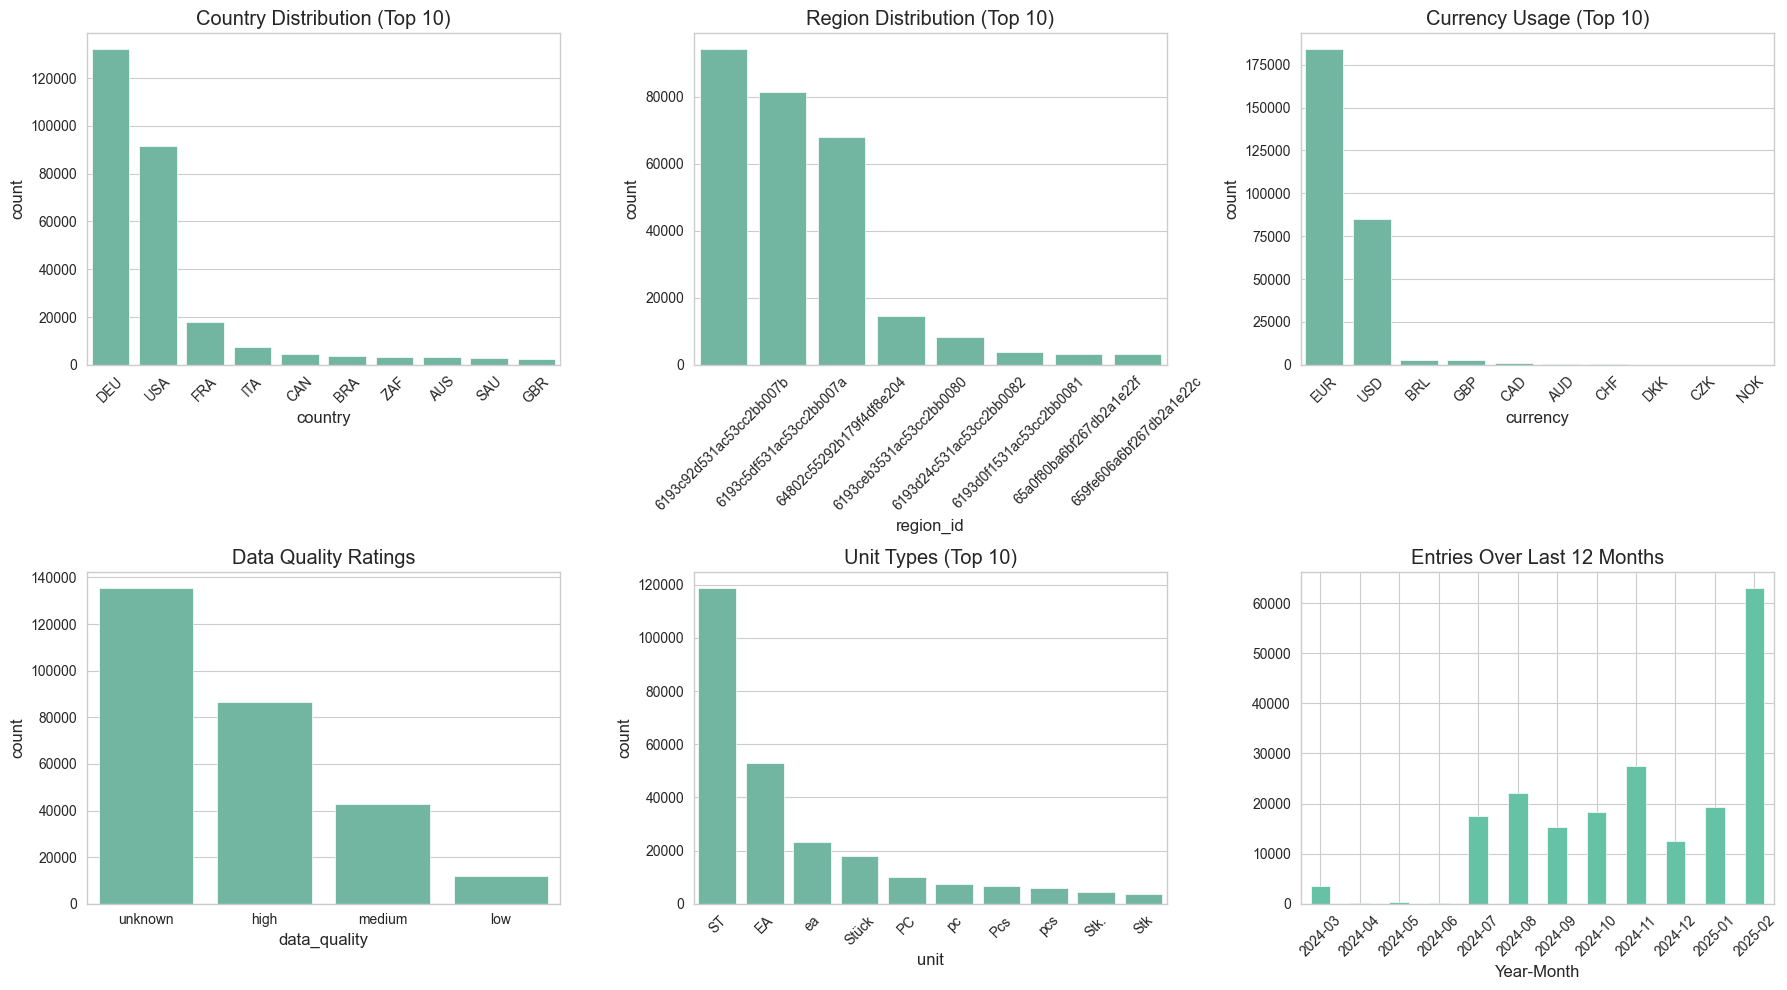

Generating sonar detail visualizations...


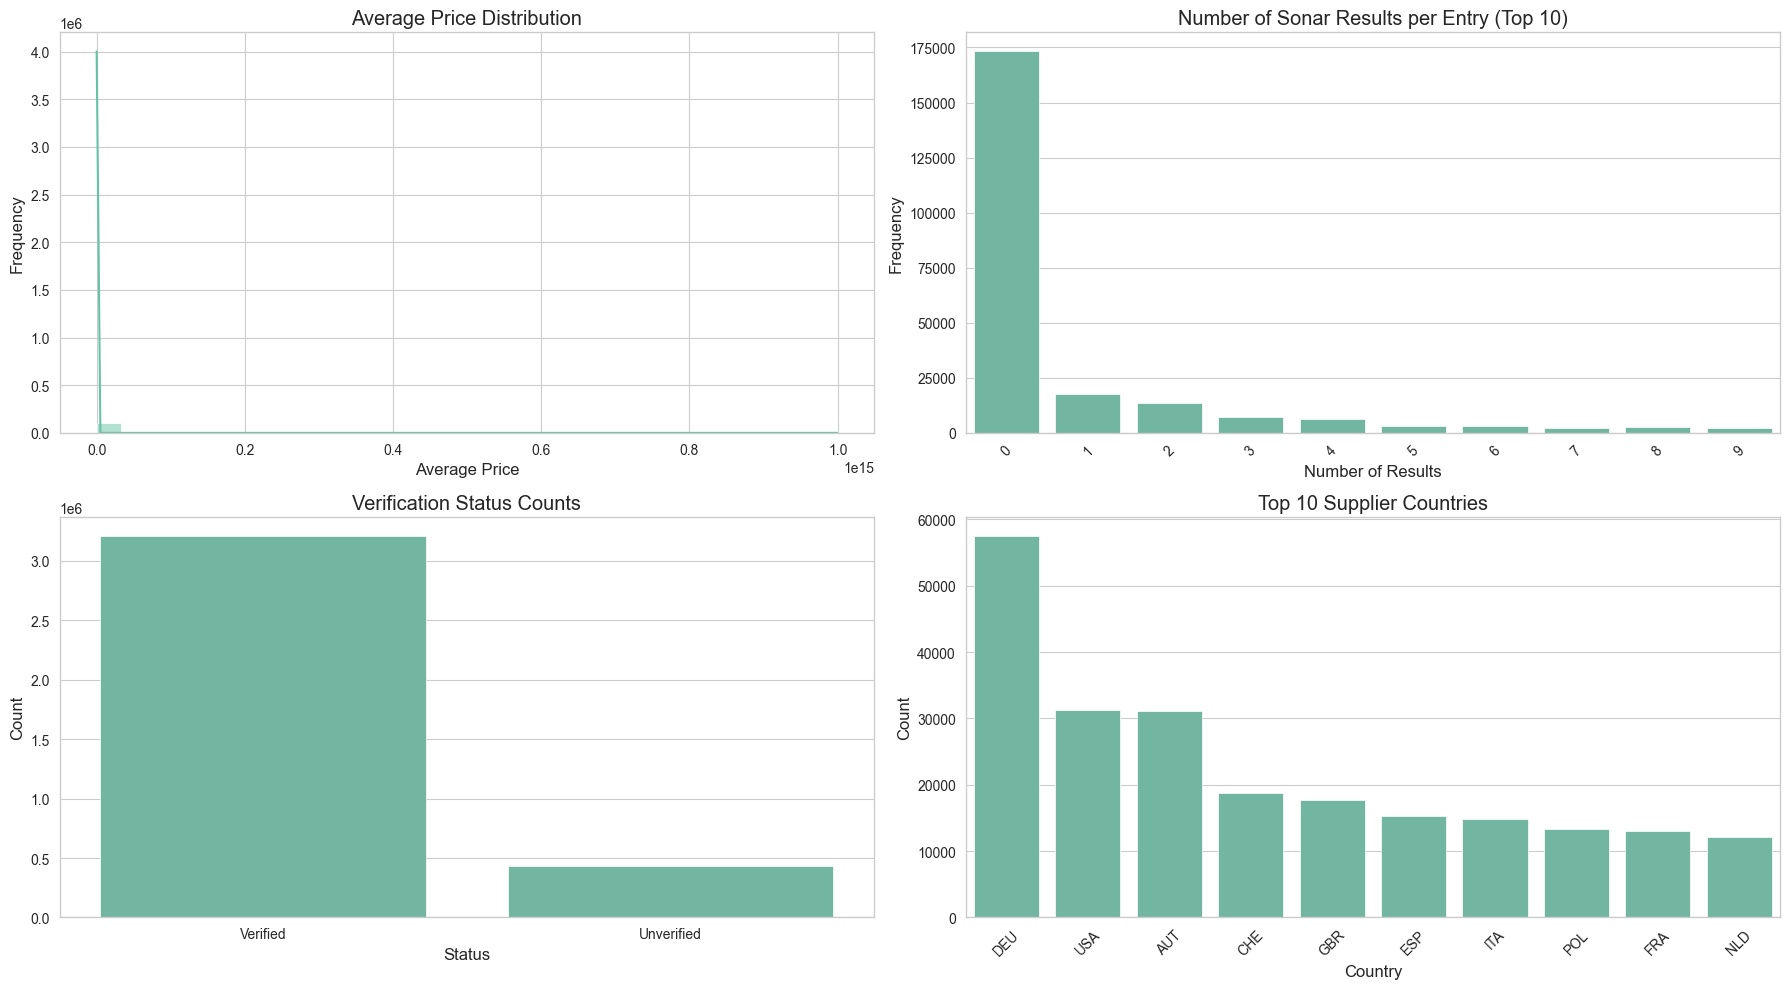

In [ ]:
run_analysis()